In [1]:
import sys
sys.path.insert(0,'..')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import training as tr
import emnet
import emsim_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

import cv2

from unet import UNet
import scipy.optimize as optimize
from scipy.optimize import curve_fit

# Regression net with line events

In [2]:
modeldir = '/home/jrenner/local/jerenner/emsim/models/regression_line'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/rl_adam.pt".format(modeldir)

line_m = -2
line_b = 15

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset_train = tr.EMDataset("../dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=-1,nstart=20000)
dset_val = tr.EMDataset("../dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=-1,nstart=0,nend=20000)

dataset_train = tr.EMFrameDataset(dset_train,frame_size=11,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=15.0,res_factor=1,lside=-1)
dataset_val = tr.EMFrameDataset(dset_val,frame_size=11,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=15.0,res_factor=1,lside=-1)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_reg_line, num_workers=1)

# Define the model.
model = emnet.basicCNN_reg()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 20000 to 178917
Created dataset for events from 0 to 20000


## Train the network (regression with line)

In [3]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_regression_line(model, epoch, train_loader, optimizer, line_m, line_b)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  0


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [0/1000 (0%)]	Loss: 2.002177	 score_max: 1.000000	 score_min: -0.981108; Accuracy 0.000; LR 0.001
Train Epoch: 0 [50/1000 (5%)]	Loss: 1.575717	 score_max: 0.893114	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 0 [100/1000 (10%)]	Loss: 1.649582	 score_max: 0.789951	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 0 [150/1000 (15%)]	Loss: 1.467847	 score_max: 1.000000	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 0 [200/1000 (20%)]	Loss: 1.591671	 score_max: 1.000000	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 0 [250/1000 (25%)]	Loss: 1.828257	 score_max: 1.000000	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 0 [300/1000 (30%)]	Loss: 0.996975	 score_max: 1.000000	 score_min: -1.000000; Accuracy 0.020; LR 0.001
Train Epoch: 0 [350/1000 (35%)]	Loss: 1.212567	 score_max: 1.000000	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 0 [400/1000 (40%)]	Loss: 1.245110	 score_max: 1.000000	 score_mi

Train Epoch: 3 [400/1000 (40%)]	Loss: 2.474934	 score_max: 0.990796	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 3 [450/1000 (45%)]	Loss: 0.919448	 score_max: 0.972193	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 3 [500/1000 (50%)]	Loss: 1.011055	 score_max: 0.970373	 score_min: -1.000000; Accuracy 0.020; LR 0.001
Train Epoch: 3 [550/1000 (55%)]	Loss: 0.747454	 score_max: 0.999959	 score_min: -1.000000; Accuracy 0.040; LR 0.001
Train Epoch: 3 [600/1000 (60%)]	Loss: 0.853962	 score_max: 0.799419	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 3 [650/1000 (65%)]	Loss: 0.898790	 score_max: 0.915244	 score_min: -1.000000; Accuracy 0.040; LR 0.001
Train Epoch: 3 [700/1000 (70%)]	Loss: 1.178650	 score_max: 0.837863	 score_min: -1.000000; Accuracy 0.020; LR 0.001
Train Epoch: 3 [750/1000 (75%)]	Loss: 0.557409	 score_max: 0.963251	 score_min: -1.000000; Accuracy 0.040; LR 0.001
Train Epoch: 3 [800/1000 (80%)]	Loss: 1.236321	 score_max: 0.848074	 sco

Train Epoch: 6 [800/1000 (80%)]	Loss: 0.485623	 score_max: 0.759481	 score_min: -0.999343; Accuracy 0.020; LR 0.001
Train Epoch: 6 [850/1000 (85%)]	Loss: 0.620816	 score_max: 0.796221	 score_min: -0.997385; Accuracy 0.000; LR 0.001
Train Epoch: 6 [900/1000 (90%)]	Loss: 0.319597	 score_max: 0.797892	 score_min: -0.999982; Accuracy 0.020; LR 0.001
Train Epoch: 6 [950/1000 (95%)]	Loss: 0.498853	 score_max: 0.964754	 score_min: -0.997782; Accuracy 0.020; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.5478886812925339 (VEC: 0.17998269572854042 , DIST: 0.3679059825837612 ) ACCURACY: 0.018999999575316905
Epoch:  7
Train Epoch: 7 [0/1000 (0%)]	Loss: 0.430926	 score_max: 0.992187	 score_min: -0.993812; Accuracy 0.000; LR 0.001
Train Epoch: 7 [50/1000 (5%)]	Loss: 0.437333	 score_max: 0.986767	 score_min: -0.940542; Accuracy 0.020; LR 0.001
Train Epoch: 7 [100/1000 (10%)]	Loss: 0.494630	 score_max: 0.970190	 score_min: -0.896145; Accuracy 0.040; LR 0.001
Train Epoch: 7 [150/1000 (15%)]	Loss: 0.485556	 score

Train Epoch: 10 [100/1000 (10%)]	Loss: 0.856091	 score_max: 0.736924	 score_min: -1.000000; Accuracy 0.020; LR 0.001
Train Epoch: 10 [150/1000 (15%)]	Loss: 1.499766	 score_max: 0.488343	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 10 [200/1000 (20%)]	Loss: 0.792067	 score_max: 0.641188	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 10 [250/1000 (25%)]	Loss: 0.858929	 score_max: 0.703775	 score_min: -1.000000; Accuracy 0.080; LR 0.001
Train Epoch: 10 [300/1000 (30%)]	Loss: 0.811699	 score_max: 0.843830	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 10 [350/1000 (35%)]	Loss: 0.938680	 score_max: 0.656974	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 10 [400/1000 (40%)]	Loss: 2.536760	 score_max: 0.962842	 score_min: -1.000000; Accuracy 0.020; LR 0.001
Train Epoch: 10 [450/1000 (45%)]	Loss: 2.109789	 score_max: 0.728063	 score_min: -1.000000; Accuracy 0.020; LR 0.001
Train Epoch: 10 [500/1000 (50%)]	Loss: 0.800534	 score_max: 0.99

Train Epoch: 13 [450/1000 (45%)]	Loss: 0.563716	 score_max: 0.448577	 score_min: -1.000000; Accuracy 0.020; LR 0.001
Train Epoch: 13 [500/1000 (50%)]	Loss: 0.547547	 score_max: 0.997062	 score_min: -0.895816; Accuracy 0.020; LR 0.001
Train Epoch: 13 [550/1000 (55%)]	Loss: 0.869810	 score_max: 0.831983	 score_min: -0.999990; Accuracy 0.020; LR 0.001
Train Epoch: 13 [600/1000 (60%)]	Loss: 0.411294	 score_max: 0.960205	 score_min: -0.996402; Accuracy 0.000; LR 0.001
Train Epoch: 13 [650/1000 (65%)]	Loss: 0.412277	 score_max: 0.694456	 score_min: -0.838025; Accuracy 0.020; LR 0.001
Train Epoch: 13 [700/1000 (70%)]	Loss: 0.404604	 score_max: 0.979778	 score_min: -0.699830; Accuracy 0.000; LR 0.001
Train Epoch: 13 [750/1000 (75%)]	Loss: 0.384802	 score_max: 0.992907	 score_min: -0.943455; Accuracy 0.060; LR 0.001
Train Epoch: 13 [800/1000 (80%)]	Loss: 1.025179	 score_max: 0.885870	 score_min: -0.993068; Accuracy 0.020; LR 0.001
Train Epoch: 13 [850/1000 (85%)]	Loss: 0.421251	 score_max: 0.94

Train Epoch: 16 [800/1000 (80%)]	Loss: 0.475770	 score_max: 0.928247	 score_min: -0.998387; Accuracy 0.000; LR 0.001
Train Epoch: 16 [850/1000 (85%)]	Loss: 0.663327	 score_max: 0.602988	 score_min: -0.999946; Accuracy 0.020; LR 0.001
Train Epoch: 16 [900/1000 (90%)]	Loss: 0.408243	 score_max: 0.557301	 score_min: -0.954478; Accuracy 0.000; LR 0.001
Train Epoch: 16 [950/1000 (95%)]	Loss: 0.435498	 score_max: 0.950448	 score_min: -0.956194; Accuracy 0.000; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.5133894175291062 (VEC: 0.18295055106282235 , DIST: 0.33043887093663216 ) ACCURACY: 0.026999999396502973
Epoch:  17
Train Epoch: 17 [0/1000 (0%)]	Loss: 0.413223	 score_max: 0.880787	 score_min: -0.999999; Accuracy 0.020; LR 0.001
Train Epoch: 17 [50/1000 (5%)]	Loss: 0.268982	 score_max: 0.638358	 score_min: -0.997088; Accuracy 0.000; LR 0.001
Train Epoch: 17 [100/1000 (10%)]	Loss: 0.359088	 score_max: 0.595550	 score_min: -1.000000; Accuracy 0.020; LR 0.001
Train Epoch: 17 [150/1000 (15%)]	Loss: 0.524

Train Epoch: 20 [100/1000 (10%)]	Loss: 0.475736	 score_max: 0.889703	 score_min: -0.999663; Accuracy 0.000; LR 0.001
Train Epoch: 20 [150/1000 (15%)]	Loss: 1.029816	 score_max: 0.823498	 score_min: -0.999438; Accuracy 0.020; LR 0.001
Train Epoch: 20 [200/1000 (20%)]	Loss: 0.589321	 score_max: 0.551505	 score_min: -0.987844; Accuracy 0.000; LR 0.001
Train Epoch: 20 [250/1000 (25%)]	Loss: 0.589886	 score_max: 0.519359	 score_min: -0.999982; Accuracy 0.000; LR 0.001
Train Epoch: 20 [300/1000 (30%)]	Loss: 0.444889	 score_max: 0.329332	 score_min: -1.000000; Accuracy 0.000; LR 0.001
Train Epoch: 20 [350/1000 (35%)]	Loss: 0.406094	 score_max: 0.442625	 score_min: -0.993198; Accuracy 0.060; LR 0.001
Train Epoch: 20 [400/1000 (40%)]	Loss: 0.685785	 score_max: 0.536163	 score_min: -0.999671; Accuracy 0.040; LR 0.001
Train Epoch: 20 [450/1000 (45%)]	Loss: 0.990495	 score_max: 0.500755	 score_min: -0.999990; Accuracy 0.000; LR 0.001
Train Epoch: 20 [500/1000 (50%)]	Loss: 0.554046	 score_max: 0.77

Train Epoch: 23 [450/1000 (45%)]	Loss: 0.349181	 score_max: 0.532262	 score_min: -0.999982; Accuracy 0.040; LR 0.001
Train Epoch: 23 [500/1000 (50%)]	Loss: 0.493969	 score_max: 0.541753	 score_min: -0.999296; Accuracy 0.000; LR 0.001
Train Epoch: 23 [550/1000 (55%)]	Loss: 0.351524	 score_max: 0.377961	 score_min: -0.898900; Accuracy 0.040; LR 0.001
Train Epoch: 23 [600/1000 (60%)]	Loss: 0.427005	 score_max: 0.878578	 score_min: -1.000000; Accuracy 0.040; LR 0.001
Train Epoch: 23 [650/1000 (65%)]	Loss: 0.702554	 score_max: 0.940332	 score_min: -0.984737; Accuracy 0.040; LR 0.001
Train Epoch: 23 [700/1000 (70%)]	Loss: 0.481483	 score_max: 0.811246	 score_min: -0.996064; Accuracy 0.100; LR 0.001
Train Epoch: 23 [750/1000 (75%)]	Loss: 0.399895	 score_max: 0.989706	 score_min: -0.984143; Accuracy 0.000; LR 0.001
Train Epoch: 23 [800/1000 (80%)]	Loss: 0.431846	 score_max: 0.786345	 score_min: -0.998827; Accuracy 0.000; LR 0.001
Train Epoch: 23 [850/1000 (85%)]	Loss: 0.348040	 score_max: 0.96

Train Epoch: 26 [800/1000 (80%)]	Loss: 0.664942	 score_max: 0.902870	 score_min: -0.993329; Accuracy 0.000; LR 0.001
Train Epoch: 26 [850/1000 (85%)]	Loss: 0.456419	 score_max: 0.945030	 score_min: -0.801677; Accuracy 0.020; LR 0.001
Train Epoch: 26 [900/1000 (90%)]	Loss: 0.350942	 score_max: 0.630997	 score_min: -0.821982; Accuracy 0.040; LR 0.001
Train Epoch: 26 [950/1000 (95%)]	Loss: 1.164529	 score_max: 0.770047	 score_min: -0.971531; Accuracy 0.020; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.5489571340382099 (VEC: 0.10351738315075636 , DIST: 0.44543974921107293 ) ACCURACY: 0.030999999307096005
Epoch:  27
Train Epoch: 27 [0/1000 (0%)]	Loss: 0.377644	 score_max: 0.753954	 score_min: -0.988123; Accuracy 0.060; LR 0.001
Train Epoch: 27 [50/1000 (5%)]	Loss: 0.389327	 score_max: 0.792092	 score_min: -0.664369; Accuracy 0.040; LR 0.001
Train Epoch: 27 [100/1000 (10%)]	Loss: 0.327198	 score_max: 0.727574	 score_min: -0.854955; Accuracy 0.040; LR 0.001
Train Epoch: 27 [150/1000 (15%)]	Loss: 0.334

Train Epoch: 30 [100/1000 (10%)]	Loss: 0.661745	 score_max: 0.583674	 score_min: -0.988512; Accuracy 0.040; LR 0.001
Train Epoch: 30 [150/1000 (15%)]	Loss: 4.158556	 score_max: 0.421656	 score_min: -0.289090; Accuracy 0.040; LR 0.001
Train Epoch: 30 [200/1000 (20%)]	Loss: 0.420692	 score_max: 0.886224	 score_min: -0.347538; Accuracy 0.020; LR 0.001
Train Epoch: 30 [250/1000 (25%)]	Loss: 0.451303	 score_max: 0.838177	 score_min: -0.819619; Accuracy 0.040; LR 0.001
Train Epoch: 30 [300/1000 (30%)]	Loss: 0.410144	 score_max: 0.706067	 score_min: -0.784894; Accuracy 0.000; LR 0.001
Train Epoch: 30 [350/1000 (35%)]	Loss: 0.434027	 score_max: 0.711336	 score_min: -0.802493; Accuracy 0.020; LR 0.001
Train Epoch: 30 [400/1000 (40%)]	Loss: 0.671958	 score_max: 0.970669	 score_min: -0.873600; Accuracy 0.060; LR 0.001
Train Epoch: 30 [450/1000 (45%)]	Loss: 0.299132	 score_max: 0.981704	 score_min: -0.460835; Accuracy 0.040; LR 0.001
Train Epoch: 30 [500/1000 (50%)]	Loss: 0.490199	 score_max: 0.85

Train Epoch: 33 [450/1000 (45%)]	Loss: 0.805345	 score_max: 0.633395	 score_min: -0.980438; Accuracy 0.080; LR 0.001
Train Epoch: 33 [500/1000 (50%)]	Loss: 0.291375	 score_max: 0.161840	 score_min: -0.931959; Accuracy 0.000; LR 0.001
Train Epoch: 33 [550/1000 (55%)]	Loss: 0.550277	 score_max: 0.375761	 score_min: -0.877154; Accuracy 0.020; LR 0.001
Train Epoch: 33 [600/1000 (60%)]	Loss: 0.242192	 score_max: 0.375188	 score_min: -0.937645; Accuracy 0.040; LR 0.001
Train Epoch: 33 [650/1000 (65%)]	Loss: 0.547208	 score_max: 0.601119	 score_min: -0.913233; Accuracy 0.060; LR 0.001
Train Epoch: 33 [700/1000 (70%)]	Loss: 0.273739	 score_max: 0.549090	 score_min: -0.562140; Accuracy 0.040; LR 0.001
Train Epoch: 33 [750/1000 (75%)]	Loss: 0.360848	 score_max: 0.890709	 score_min: -0.931773; Accuracy 0.000; LR 0.001
Train Epoch: 33 [800/1000 (80%)]	Loss: 0.384281	 score_max: 0.672679	 score_min: -0.980548; Accuracy 0.020; LR 0.001
Train Epoch: 33 [850/1000 (85%)]	Loss: 0.432623	 score_max: 0.85

Train Epoch: 36 [800/1000 (80%)]	Loss: 0.374619	 score_max: 0.721385	 score_min: -0.717105; Accuracy 0.000; LR 0.001
Train Epoch: 36 [850/1000 (85%)]	Loss: 0.615300	 score_max: 0.622026	 score_min: -0.717628; Accuracy 0.040; LR 0.001
Train Epoch: 36 [900/1000 (90%)]	Loss: 0.247474	 score_max: 0.749972	 score_min: -0.744189; Accuracy 0.020; LR 0.001
Train Epoch: 36 [950/1000 (95%)]	Loss: 0.297895	 score_max: 0.374680	 score_min: -0.713002; Accuracy 0.020; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.5294764563441277 (VEC: 0.06403920697048307 , DIST: 0.4654372476041317 ) ACCURACY: 0.018999999575316905
Epoch:  37
Train Epoch: 37 [0/1000 (0%)]	Loss: 0.246673	 score_max: 0.289182	 score_min: -0.688970; Accuracy 0.000; LR 0.001
Train Epoch: 37 [50/1000 (5%)]	Loss: 0.380174	 score_max: 0.692492	 score_min: -0.855226; Accuracy 0.020; LR 0.001
Train Epoch: 37 [100/1000 (10%)]	Loss: 0.263343	 score_max: 0.514019	 score_min: -0.800315; Accuracy 0.000; LR 0.001
Train Epoch: 37 [150/1000 (15%)]	Loss: 0.3776

Train Epoch: 40 [100/1000 (10%)]	Loss: 0.359409	 score_max: 0.527202	 score_min: -0.946459; Accuracy 0.040; LR 0.001
Train Epoch: 40 [150/1000 (15%)]	Loss: 0.644161	 score_max: 0.595018	 score_min: -0.997819; Accuracy 0.020; LR 0.001
Train Epoch: 40 [200/1000 (20%)]	Loss: 0.521358	 score_max: 0.757820	 score_min: -0.820854; Accuracy 0.040; LR 0.001
Train Epoch: 40 [250/1000 (25%)]	Loss: 0.345831	 score_max: 0.861699	 score_min: -0.500801; Accuracy 0.020; LR 0.001
Train Epoch: 40 [300/1000 (30%)]	Loss: 0.488024	 score_max: 0.883972	 score_min: -0.763055; Accuracy 0.000; LR 0.001
Train Epoch: 40 [350/1000 (35%)]	Loss: 0.331470	 score_max: 0.991378	 score_min: -0.434152; Accuracy 0.040; LR 0.001
Train Epoch: 40 [400/1000 (40%)]	Loss: 0.362201	 score_max: 0.913261	 score_min: -0.676199; Accuracy 0.080; LR 0.001
Train Epoch: 40 [450/1000 (45%)]	Loss: 0.603011	 score_max: 0.882223	 score_min: -0.893588; Accuracy 0.020; LR 0.001
Train Epoch: 40 [500/1000 (50%)]	Loss: 0.461886	 score_max: 0.72

Train Epoch: 43 [450/1000 (45%)]	Loss: 0.460312	 score_max: 0.678010	 score_min: -0.775946; Accuracy 0.040; LR 0.001
Train Epoch: 43 [500/1000 (50%)]	Loss: 0.339768	 score_max: 0.802505	 score_min: -0.682836; Accuracy 0.040; LR 0.001
Train Epoch: 43 [550/1000 (55%)]	Loss: 0.572906	 score_max: 0.423704	 score_min: -0.966602; Accuracy 0.040; LR 0.001
Train Epoch: 43 [600/1000 (60%)]	Loss: 0.250357	 score_max: 0.916898	 score_min: -0.816612; Accuracy 0.000; LR 0.001
Train Epoch: 43 [650/1000 (65%)]	Loss: 0.272271	 score_max: 0.545800	 score_min: -0.398871; Accuracy 0.000; LR 0.001
Train Epoch: 43 [700/1000 (70%)]	Loss: 0.340520	 score_max: 0.643372	 score_min: -0.992274; Accuracy 0.000; LR 0.001
Train Epoch: 43 [750/1000 (75%)]	Loss: 0.274857	 score_max: 0.687897	 score_min: -0.997009; Accuracy 0.000; LR 0.001
Train Epoch: 43 [800/1000 (80%)]	Loss: 0.248635	 score_max: 0.725248	 score_min: -0.364186; Accuracy 0.040; LR 0.001
Train Epoch: 43 [850/1000 (85%)]	Loss: 0.307696	 score_max: 0.61

Train Epoch: 46 [800/1000 (80%)]	Loss: 0.239512	 score_max: 0.548560	 score_min: -0.819080; Accuracy 0.000; LR 0.001
Train Epoch: 46 [850/1000 (85%)]	Loss: 0.349945	 score_max: 0.412645	 score_min: -0.955437; Accuracy 0.020; LR 0.001
Train Epoch: 46 [900/1000 (90%)]	Loss: 0.328333	 score_max: 0.390158	 score_min: -0.705047; Accuracy 0.020; LR 0.001
Train Epoch: 46 [950/1000 (95%)]	Loss: 0.397263	 score_max: 0.616755	 score_min: -0.535617; Accuracy 0.060; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.4800101384520531 (VEC: 0.07145727993920445 , DIST: 0.4085528589785099 ) ACCURACY: 0.020999999530613423
Epoch:  47
Train Epoch: 47 [0/1000 (0%)]	Loss: 0.242555	 score_max: 0.779011	 score_min: -0.554466; Accuracy 0.000; LR 0.001
Train Epoch: 47 [50/1000 (5%)]	Loss: 0.657868	 score_max: 0.854487	 score_min: -0.670817; Accuracy 0.020; LR 0.001
Train Epoch: 47 [100/1000 (10%)]	Loss: 0.315855	 score_max: 0.623826	 score_min: -0.405205; Accuracy 0.040; LR 0.001
Train Epoch: 47 [150/1000 (15%)]	Loss: 0.3349

Train Epoch: 50 [100/1000 (10%)]	Loss: 0.282581	 score_max: 0.883336	 score_min: -0.759540; Accuracy 0.020; LR 0.001
Train Epoch: 50 [150/1000 (15%)]	Loss: 0.848078	 score_max: 0.884511	 score_min: -0.853946; Accuracy 0.040; LR 0.001
Train Epoch: 50 [200/1000 (20%)]	Loss: 0.224729	 score_max: 0.190282	 score_min: -0.408583; Accuracy 0.000; LR 0.001
Train Epoch: 50 [250/1000 (25%)]	Loss: 0.359190	 score_max: 0.174309	 score_min: -0.938249; Accuracy 0.020; LR 0.001
Train Epoch: 50 [300/1000 (30%)]	Loss: 0.756140	 score_max: 0.577442	 score_min: -0.676857; Accuracy 0.020; LR 0.001
Train Epoch: 50 [350/1000 (35%)]	Loss: 0.302379	 score_max: 0.467986	 score_min: -0.867660; Accuracy 0.020; LR 0.001
Train Epoch: 50 [400/1000 (40%)]	Loss: 0.342087	 score_max: 0.382079	 score_min: -0.870333; Accuracy 0.020; LR 0.001
Train Epoch: 50 [450/1000 (45%)]	Loss: 0.247244	 score_max: 0.878776	 score_min: -0.449779; Accuracy 0.000; LR 0.001
Train Epoch: 50 [500/1000 (50%)]	Loss: 0.145348	 score_max: 0.69

Train Epoch: 53 [450/1000 (45%)]	Loss: 0.242850	 score_max: 0.388262	 score_min: -0.676114; Accuracy 0.000; LR 0.001
Train Epoch: 53 [500/1000 (50%)]	Loss: 0.654978	 score_max: 0.489724	 score_min: -0.645374; Accuracy 0.020; LR 0.001
Train Epoch: 53 [550/1000 (55%)]	Loss: 0.257502	 score_max: 0.294889	 score_min: -0.469884; Accuracy 0.000; LR 0.001
Train Epoch: 53 [600/1000 (60%)]	Loss: 0.380493	 score_max: 0.547788	 score_min: -0.251427; Accuracy 0.000; LR 0.001
Train Epoch: 53 [650/1000 (65%)]	Loss: 0.637896	 score_max: 0.695863	 score_min: -0.195188; Accuracy 0.020; LR 0.001
Train Epoch: 53 [700/1000 (70%)]	Loss: 0.313005	 score_max: 0.809766	 score_min: -0.138518; Accuracy 0.100; LR 0.001
Train Epoch: 53 [750/1000 (75%)]	Loss: 0.386194	 score_max: 0.868387	 score_min: -0.168120; Accuracy 0.000; LR 0.001
Train Epoch: 53 [800/1000 (80%)]	Loss: 0.798240	 score_max: 0.854304	 score_min: -0.804615; Accuracy 0.040; LR 0.001
Train Epoch: 53 [850/1000 (85%)]	Loss: 0.306810	 score_max: 0.74

Train Epoch: 56 [800/1000 (80%)]	Loss: 0.577065	 score_max: 0.271081	 score_min: -0.998694; Accuracy 0.020; LR 0.001
Train Epoch: 56 [850/1000 (85%)]	Loss: 0.303226	 score_max: 0.671845	 score_min: -0.985991; Accuracy 0.040; LR 0.001
Train Epoch: 56 [900/1000 (90%)]	Loss: 0.329798	 score_max: 0.235076	 score_min: -0.991015; Accuracy 0.000; LR 0.001
Train Epoch: 56 [950/1000 (95%)]	Loss: 0.247152	 score_max: 0.149343	 score_min: -0.992753; Accuracy 0.000; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.43986925184726716 (VEC: 0.0572100761346519 , DIST: 0.38265917375683783 ) ACCURACY: 0.029999999329447746
Epoch:  57
Train Epoch: 57 [0/1000 (0%)]	Loss: 0.292803	 score_max: 0.106765	 score_min: -0.835086; Accuracy 0.020; LR 0.001
Train Epoch: 57 [50/1000 (5%)]	Loss: 0.439219	 score_max: 0.436140	 score_min: -0.763201; Accuracy 0.020; LR 0.001
Train Epoch: 57 [100/1000 (10%)]	Loss: 0.313595	 score_max: 0.101278	 score_min: -0.871602; Accuracy 0.040; LR 0.001
Train Epoch: 57 [150/1000 (15%)]	Loss: 0.250

Train Epoch: 60 [100/1000 (10%)]	Loss: 0.472798	 score_max: 0.362088	 score_min: -0.997920; Accuracy 0.060; LR 0.001
Train Epoch: 60 [150/1000 (15%)]	Loss: 0.899212	 score_max: 0.370537	 score_min: -0.999921; Accuracy 0.060; LR 0.001
Train Epoch: 60 [200/1000 (20%)]	Loss: 0.436915	 score_max: 0.281484	 score_min: -0.999844; Accuracy 0.040; LR 0.001
Train Epoch: 60 [250/1000 (25%)]	Loss: 0.434434	 score_max: 0.335853	 score_min: -0.992463; Accuracy 0.020; LR 0.001
Train Epoch: 60 [300/1000 (30%)]	Loss: 0.349475	 score_max: 0.332333	 score_min: -0.989984; Accuracy 0.020; LR 0.001
Train Epoch: 60 [350/1000 (35%)]	Loss: 0.365609	 score_max: 0.382389	 score_min: -0.999999; Accuracy 0.020; LR 0.001
Train Epoch: 60 [400/1000 (40%)]	Loss: 0.351080	 score_max: 0.415586	 score_min: -0.999997; Accuracy 0.000; LR 0.001
Train Epoch: 60 [450/1000 (45%)]	Loss: 0.253614	 score_max: 0.183314	 score_min: -0.999868; Accuracy 0.040; LR 0.001
Train Epoch: 60 [500/1000 (50%)]	Loss: 0.591910	 score_max: 0.32

Train Epoch: 63 [450/1000 (45%)]	Loss: 1.146362	 score_max: 0.256109	 score_min: -0.646252; Accuracy 0.000; LR 0.001
Train Epoch: 63 [500/1000 (50%)]	Loss: 1.988819	 score_max: 0.235655	 score_min: -0.728560; Accuracy 0.020; LR 0.001
Train Epoch: 63 [550/1000 (55%)]	Loss: 0.279855	 score_max: 0.132552	 score_min: -0.738989; Accuracy 0.020; LR 0.001
Train Epoch: 63 [600/1000 (60%)]	Loss: 0.543589	 score_max: 0.360987	 score_min: -0.572043; Accuracy 0.000; LR 0.001
Train Epoch: 63 [650/1000 (65%)]	Loss: 0.265778	 score_max: 0.235865	 score_min: -0.651825; Accuracy 0.020; LR 0.001
Train Epoch: 63 [700/1000 (70%)]	Loss: 0.347127	 score_max: 0.417716	 score_min: -0.918497; Accuracy 0.040; LR 0.001
Train Epoch: 63 [750/1000 (75%)]	Loss: 0.461234	 score_max: 0.133275	 score_min: -0.990603; Accuracy 0.040; LR 0.001
Train Epoch: 63 [800/1000 (80%)]	Loss: 0.393387	 score_max: 0.234956	 score_min: -0.994214; Accuracy 0.000; LR 0.001
Train Epoch: 63 [850/1000 (85%)]	Loss: 0.266929	 score_max: 0.37

Train Epoch: 66 [800/1000 (80%)]	Loss: 0.279356	 score_max: 0.688080	 score_min: -0.818182; Accuracy 0.000; LR 0.001
Train Epoch: 66 [850/1000 (85%)]	Loss: 0.129164	 score_max: 0.263712	 score_min: -0.248789; Accuracy 0.000; LR 0.001
Train Epoch: 66 [900/1000 (90%)]	Loss: 0.543542	 score_max: 0.467361	 score_min: -0.531236; Accuracy 0.000; LR 0.001
Train Epoch: 66 [950/1000 (95%)]	Loss: 0.216891	 score_max: 0.425499	 score_min: -0.397382; Accuracy 0.000; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.35747295841574667 (VEC: 0.029767566174268723 , DIST: 0.32770539037883284 ) ACCURACY: 0.012999999709427357
Epoch:  67
Train Epoch: 67 [0/1000 (0%)]	Loss: 0.439406	 score_max: 0.313260	 score_min: -0.438786; Accuracy 0.000; LR 0.001
Train Epoch: 67 [50/1000 (5%)]	Loss: 0.284223	 score_max: 0.565430	 score_min: -0.193951; Accuracy 0.020; LR 0.001
Train Epoch: 67 [100/1000 (10%)]	Loss: 0.236408	 score_max: 0.745695	 score_min: -0.982454; Accuracy 0.000; LR 0.001
Train Epoch: 67 [150/1000 (15%)]	Loss: 0.3

Train Epoch: 70 [100/1000 (10%)]	Loss: 0.825147	 score_max: 0.281551	 score_min: -0.938781; Accuracy 0.020; LR 0.001
Train Epoch: 70 [150/1000 (15%)]	Loss: 0.673678	 score_max: 0.426675	 score_min: -0.801871; Accuracy 0.020; LR 0.001
Train Epoch: 70 [200/1000 (20%)]	Loss: 0.310385	 score_max: 0.536366	 score_min: -0.354013; Accuracy 0.040; LR 0.001
Train Epoch: 70 [250/1000 (25%)]	Loss: 0.323400	 score_max: 0.496822	 score_min: -0.617617; Accuracy 0.020; LR 0.001
Train Epoch: 70 [300/1000 (30%)]	Loss: 0.962221	 score_max: 0.769843	 score_min: -0.548077; Accuracy 0.000; LR 0.001
Train Epoch: 70 [350/1000 (35%)]	Loss: 0.390372	 score_max: 0.088392	 score_min: -0.521833; Accuracy 0.060; LR 0.001
Train Epoch: 70 [400/1000 (40%)]	Loss: 0.231473	 score_max: 0.896985	 score_min: -0.578257; Accuracy 0.080; LR 0.001
Train Epoch: 70 [450/1000 (45%)]	Loss: 0.409377	 score_max: 0.689849	 score_min: -0.283900; Accuracy 0.020; LR 0.001
Train Epoch: 70 [500/1000 (50%)]	Loss: 0.424705	 score_max: 0.28

Train Epoch: 73 [450/1000 (45%)]	Loss: 0.660648	 score_max: 0.587512	 score_min: -0.384903; Accuracy 0.020; LR 0.001
Train Epoch: 73 [500/1000 (50%)]	Loss: 0.294764	 score_max: 0.546059	 score_min: -0.970745; Accuracy 0.040; LR 0.001
Train Epoch: 73 [550/1000 (55%)]	Loss: 0.251992	 score_max: 0.401495	 score_min: -0.142003; Accuracy 0.000; LR 0.001
Train Epoch: 73 [600/1000 (60%)]	Loss: 0.207855	 score_max: 0.351580	 score_min: -0.472643; Accuracy 0.060; LR 0.001
Train Epoch: 73 [650/1000 (65%)]	Loss: 0.290217	 score_max: 0.619946	 score_min: -0.526016; Accuracy 0.040; LR 0.001
Train Epoch: 73 [700/1000 (70%)]	Loss: 0.299837	 score_max: 0.442329	 score_min: -0.787409; Accuracy 0.040; LR 0.001
Train Epoch: 73 [750/1000 (75%)]	Loss: 0.215130	 score_max: 0.589288	 score_min: -0.088674; Accuracy 0.040; LR 0.001
Train Epoch: 73 [800/1000 (80%)]	Loss: 0.183817	 score_max: 0.262702	 score_min: -0.394504; Accuracy 0.000; LR 0.001
Train Epoch: 73 [850/1000 (85%)]	Loss: 0.215513	 score_max: 0.39

Train Epoch: 76 [800/1000 (80%)]	Loss: 0.216629	 score_max: 0.145764	 score_min: -0.984791; Accuracy 0.080; LR 0.001
Train Epoch: 76 [850/1000 (85%)]	Loss: 0.284838	 score_max: 0.407710	 score_min: -0.837763; Accuracy 0.020; LR 0.001
Train Epoch: 76 [900/1000 (90%)]	Loss: 0.245743	 score_max: 0.304445	 score_min: -0.096453; Accuracy 0.000; LR 0.001
Train Epoch: 76 [950/1000 (95%)]	Loss: 0.690194	 score_max: 0.229116	 score_min: -0.629895; Accuracy 0.000; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.384673423320055 (VEC: 0.03807778120972216 , DIST: 0.34659564048051833 ) ACCURACY: 0.029999999329447746
Epoch:  77
Train Epoch: 77 [0/1000 (0%)]	Loss: 0.266216	 score_max: 0.353109	 score_min: -0.792024; Accuracy 0.040; LR 0.001
Train Epoch: 77 [50/1000 (5%)]	Loss: 0.694557	 score_max: 0.457661	 score_min: -0.212237; Accuracy 0.040; LR 0.001
Train Epoch: 77 [100/1000 (10%)]	Loss: 0.224578	 score_max: 0.281454	 score_min: -0.594188; Accuracy 0.020; LR 0.001
Train Epoch: 77 [150/1000 (15%)]	Loss: 0.3123

Train Epoch: 80 [100/1000 (10%)]	Loss: 0.352419	 score_max: 0.294046	 score_min: -0.121616; Accuracy 0.020; LR 0.001
Train Epoch: 80 [150/1000 (15%)]	Loss: 0.368057	 score_max: 0.060149	 score_min: -0.344660; Accuracy 0.000; LR 0.001
Train Epoch: 80 [200/1000 (20%)]	Loss: 0.239929	 score_max: 0.259162	 score_min: -0.375474; Accuracy 0.040; LR 0.001
Train Epoch: 80 [250/1000 (25%)]	Loss: 0.265330	 score_max: 0.285192	 score_min: -0.196133; Accuracy 0.080; LR 0.001
Train Epoch: 80 [300/1000 (30%)]	Loss: 0.275420	 score_max: 0.256057	 score_min: -0.498569; Accuracy 0.060; LR 0.001
Train Epoch: 80 [350/1000 (35%)]	Loss: 0.337274	 score_max: 0.082776	 score_min: -0.525004; Accuracy 0.020; LR 0.001
Train Epoch: 80 [400/1000 (40%)]	Loss: 0.287137	 score_max: 0.169735	 score_min: -0.334940; Accuracy 0.000; LR 0.001
Train Epoch: 80 [450/1000 (45%)]	Loss: 0.386990	 score_max: 0.237399	 score_min: -0.553458; Accuracy 0.040; LR 0.001
Train Epoch: 80 [500/1000 (50%)]	Loss: 0.214263	 score_max: 0.47

Train Epoch: 83 [450/1000 (45%)]	Loss: 0.279718	 score_max: 0.336191	 score_min: -0.696270; Accuracy 0.020; LR 0.001
Train Epoch: 83 [500/1000 (50%)]	Loss: 0.237097	 score_max: 0.223153	 score_min: -0.115510; Accuracy 0.000; LR 0.001
Train Epoch: 83 [550/1000 (55%)]	Loss: 0.181150	 score_max: 0.394527	 score_min: -0.139304; Accuracy 0.000; LR 0.001
Train Epoch: 83 [600/1000 (60%)]	Loss: 0.216404	 score_max: 0.329054	 score_min: -0.617241; Accuracy 0.060; LR 0.001
Train Epoch: 83 [650/1000 (65%)]	Loss: 0.265214	 score_max: 0.669918	 score_min: -0.149803; Accuracy 0.080; LR 0.001
Train Epoch: 83 [700/1000 (70%)]	Loss: 0.294036	 score_max: 0.340960	 score_min: -0.157626; Accuracy 0.020; LR 0.001
Train Epoch: 83 [750/1000 (75%)]	Loss: 0.242848	 score_max: 0.211987	 score_min: -0.508445; Accuracy 0.020; LR 0.001
Train Epoch: 83 [800/1000 (80%)]	Loss: 0.396381	 score_max: 0.396693	 score_min: -0.272177; Accuracy 0.000; LR 0.001
Train Epoch: 83 [850/1000 (85%)]	Loss: 0.516390	 score_max: 0.31

Train Epoch: 86 [800/1000 (80%)]	Loss: 1.003150	 score_max: 0.328779	 score_min: -0.408989; Accuracy 0.000; LR 0.001
Train Epoch: 86 [850/1000 (85%)]	Loss: 0.299669	 score_max: 0.191956	 score_min: -0.364162; Accuracy 0.020; LR 0.001
Train Epoch: 86 [900/1000 (90%)]	Loss: 0.440923	 score_max: 0.396374	 score_min: -0.533181; Accuracy 0.040; LR 0.001
Train Epoch: 86 [950/1000 (95%)]	Loss: 0.403577	 score_max: 0.250182	 score_min: -0.866604; Accuracy 0.020; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.3469007320702076 (VEC: 0.02331473040394485 , DIST: 0.3235859990119934 ) ACCURACY: 0.028999999351799487
Epoch:  87
Train Epoch: 87 [0/1000 (0%)]	Loss: 0.358366	 score_max: 0.303190	 score_min: -0.036198; Accuracy 0.040; LR 0.001
Train Epoch: 87 [50/1000 (5%)]	Loss: 0.294851	 score_max: 0.205257	 score_min: -0.483522; Accuracy 0.000; LR 0.001
Train Epoch: 87 [100/1000 (10%)]	Loss: 0.467542	 score_max: 0.224705	 score_min: -0.875313; Accuracy 0.000; LR 0.001
Train Epoch: 87 [150/1000 (15%)]	Loss: 0.2078

Train Epoch: 90 [100/1000 (10%)]	Loss: 0.330545	 score_max: 0.378477	 score_min: -0.283937; Accuracy 0.000; LR 0.001
Train Epoch: 90 [150/1000 (15%)]	Loss: 0.285728	 score_max: 0.290772	 score_min: -0.994841; Accuracy 0.020; LR 0.001
Train Epoch: 90 [200/1000 (20%)]	Loss: 0.202674	 score_max: 0.193136	 score_min: -0.971417; Accuracy 0.020; LR 0.001
Train Epoch: 90 [250/1000 (25%)]	Loss: 0.302671	 score_max: 0.446061	 score_min: -0.944668; Accuracy 0.020; LR 0.001
Train Epoch: 90 [300/1000 (30%)]	Loss: 0.229791	 score_max: 0.589998	 score_min: -0.621480; Accuracy 0.020; LR 0.001
Train Epoch: 90 [350/1000 (35%)]	Loss: 0.219659	 score_max: 0.248499	 score_min: -0.223632; Accuracy 0.020; LR 0.001
Train Epoch: 90 [400/1000 (40%)]	Loss: 0.637856	 score_max: 0.321596	 score_min: -0.241738; Accuracy 0.040; LR 0.001
Train Epoch: 90 [450/1000 (45%)]	Loss: 0.252707	 score_max: 0.192380	 score_min: -0.945058; Accuracy 0.040; LR 0.001
Train Epoch: 90 [500/1000 (50%)]	Loss: 0.211758	 score_max: 0.37

Train Epoch: 93 [450/1000 (45%)]	Loss: 0.266754	 score_max: 0.504765	 score_min: -0.924761; Accuracy 0.000; LR 0.001
Train Epoch: 93 [500/1000 (50%)]	Loss: 0.267837	 score_max: 0.451789	 score_min: -0.851315; Accuracy 0.000; LR 0.001
Train Epoch: 93 [550/1000 (55%)]	Loss: 0.198019	 score_max: 0.487260	 score_min: -0.551642; Accuracy 0.020; LR 0.001
Train Epoch: 93 [600/1000 (60%)]	Loss: 0.256377	 score_max: 0.103966	 score_min: -0.149202; Accuracy 0.000; LR 0.001
Train Epoch: 93 [650/1000 (65%)]	Loss: 0.181937	 score_max: 0.234371	 score_min: -0.311907; Accuracy 0.040; LR 0.001
Train Epoch: 93 [700/1000 (70%)]	Loss: 0.313016	 score_max: 0.216025	 score_min: -0.627156; Accuracy 0.040; LR 0.001
Train Epoch: 93 [750/1000 (75%)]	Loss: 0.187013	 score_max: 0.344345	 score_min: -0.387302; Accuracy 0.000; LR 0.001
Train Epoch: 93 [800/1000 (80%)]	Loss: 0.276680	 score_max: 0.367719	 score_min: -0.697603; Accuracy 0.020; LR 0.001
Train Epoch: 93 [850/1000 (85%)]	Loss: 0.190379	 score_max: 0.36

Train Epoch: 96 [800/1000 (80%)]	Loss: 0.270775	 score_max: 0.086014	 score_min: -0.856344; Accuracy 0.040; LR 0.001
Train Epoch: 96 [850/1000 (85%)]	Loss: 0.255463	 score_max: 0.084014	 score_min: -0.845818; Accuracy 0.080; LR 0.001
Train Epoch: 96 [900/1000 (90%)]	Loss: 0.232431	 score_max: 0.864435	 score_min: -0.389500; Accuracy 0.080; LR 0.001
Train Epoch: 96 [950/1000 (95%)]	Loss: 0.290616	 score_max: 0.040240	 score_min: -0.852547; Accuracy 0.020; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.30630274713039396 (VEC: 0.025749645731411874 , DIST: 0.2805531032383442 ) ACCURACY: 0.025999999418854714
Epoch:  97
Train Epoch: 97 [0/1000 (0%)]	Loss: 0.390474	 score_max: 0.038572	 score_min: -0.790432; Accuracy 0.000; LR 0.001
Train Epoch: 97 [50/1000 (5%)]	Loss: 0.376168	 score_max: 0.192893	 score_min: -0.218729; Accuracy 0.020; LR 0.001
Train Epoch: 97 [100/1000 (10%)]	Loss: 0.439733	 score_max: 0.216442	 score_min: -0.690002; Accuracy 0.040; LR 0.001
Train Epoch: 97 [150/1000 (15%)]	Loss: 0.23

Train Epoch: 100 [100/1000 (10%)]	Loss: 0.296086	 score_max: 0.497346	 score_min: -0.136860; Accuracy 0.000; LR 0.001
Train Epoch: 100 [150/1000 (15%)]	Loss: 0.252886	 score_max: 0.700185	 score_min: -0.783218; Accuracy 0.080; LR 0.001
Train Epoch: 100 [200/1000 (20%)]	Loss: 0.707018	 score_max: 0.303551	 score_min: -0.235519; Accuracy 0.040; LR 0.001
Train Epoch: 100 [250/1000 (25%)]	Loss: 0.320433	 score_max: 0.619572	 score_min: -0.754445; Accuracy 0.060; LR 0.001
Train Epoch: 100 [300/1000 (30%)]	Loss: 0.315876	 score_max: 0.419137	 score_min: -0.863810; Accuracy 0.040; LR 0.001
Train Epoch: 100 [350/1000 (35%)]	Loss: 0.356559	 score_max: 0.588098	 score_min: -0.125057; Accuracy 0.040; LR 0.001
Train Epoch: 100 [400/1000 (40%)]	Loss: 0.550262	 score_max: 0.902365	 score_min: -0.832967; Accuracy 0.100; LR 0.001
Train Epoch: 100 [450/1000 (45%)]	Loss: 0.380244	 score_max: 0.695318	 score_min: -0.812125; Accuracy 0.020; LR 0.001
Train Epoch: 100 [500/1000 (50%)]	Loss: 0.222618	 score_

Train Epoch: 103 [400/1000 (40%)]	Loss: 0.271242	 score_max: 0.407690	 score_min: -0.565388; Accuracy 0.040; LR 0.001
Train Epoch: 103 [450/1000 (45%)]	Loss: 0.279735	 score_max: 0.480949	 score_min: -0.764341; Accuracy 0.040; LR 0.001
Train Epoch: 103 [500/1000 (50%)]	Loss: 0.246121	 score_max: 0.281602	 score_min: -0.316378; Accuracy 0.000; LR 0.001
Train Epoch: 103 [550/1000 (55%)]	Loss: 0.284248	 score_max: 0.162084	 score_min: -0.891231; Accuracy 0.000; LR 0.001
Train Epoch: 103 [600/1000 (60%)]	Loss: 0.247533	 score_max: 0.318940	 score_min: -0.703708; Accuracy 0.000; LR 0.001
Train Epoch: 103 [650/1000 (65%)]	Loss: 0.332624	 score_max: 0.370238	 score_min: -0.295045; Accuracy 0.020; LR 0.001
Train Epoch: 103 [700/1000 (70%)]	Loss: 0.237198	 score_max: 0.278487	 score_min: -0.156779; Accuracy 0.000; LR 0.001
Train Epoch: 103 [750/1000 (75%)]	Loss: 0.255580	 score_max: 0.518094	 score_min: -0.477109; Accuracy 0.000; LR 0.001
Train Epoch: 103 [800/1000 (80%)]	Loss: 0.627175	 score_

Train Epoch: 106 [700/1000 (70%)]	Loss: 0.262933	 score_max: 0.502727	 score_min: -0.972659; Accuracy 0.020; LR 0.0001
Train Epoch: 106 [750/1000 (75%)]	Loss: 0.169136	 score_max: 0.336324	 score_min: -0.734828; Accuracy 0.080; LR 0.0001
Train Epoch: 106 [800/1000 (80%)]	Loss: 0.260574	 score_max: 0.492348	 score_min: -0.657086; Accuracy 0.020; LR 0.0001
Train Epoch: 106 [850/1000 (85%)]	Loss: 0.478503	 score_max: 0.512910	 score_min: -0.568903; Accuracy 0.020; LR 0.0001
Train Epoch: 106 [900/1000 (90%)]	Loss: 0.214208	 score_max: 0.288943	 score_min: -0.919484; Accuracy 0.000; LR 0.0001
Train Epoch: 106 [950/1000 (95%)]	Loss: 0.443888	 score_max: 0.151982	 score_min: -0.838645; Accuracy 0.020; LR 0.0001
---EPOCH AVG TRAIN LOSS: 0.3211513839662075 (VEC: 0.02681093420833349 , DIST: 0.29434045031666756 ) ACCURACY: 0.025999999418854714
Epoch:  107
Train Epoch: 107 [0/1000 (0%)]	Loss: 0.312832	 score_max: 0.393746	 score_min: -0.629614; Accuracy 0.000; LR 0.0001
Train Epoch: 107 [50/1000 (

Train Epoch: 110 [0/1000 (0%)]	Loss: 0.302196	 score_max: 0.473142	 score_min: -0.278424; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [50/1000 (5%)]	Loss: 0.332486	 score_max: 0.210771	 score_min: -0.084125; Accuracy 0.020; LR 0.0001
Train Epoch: 110 [100/1000 (10%)]	Loss: 0.253836	 score_max: 0.403358	 score_min: -0.517082; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [150/1000 (15%)]	Loss: 0.275044	 score_max: 0.408035	 score_min: -0.115074; Accuracy 0.020; LR 0.0001
Train Epoch: 110 [200/1000 (20%)]	Loss: 0.591673	 score_max: 0.418186	 score_min: -0.953917; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [250/1000 (25%)]	Loss: 0.291840	 score_max: 0.844631	 score_min: -0.642856; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [300/1000 (30%)]	Loss: 0.240558	 score_max: 0.192825	 score_min: -0.629753; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [350/1000 (35%)]	Loss: 0.394868	 score_max: 0.184371	 score_min: -0.953647; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [400/1000 (40%)]	Loss: 0.286432	 sco

Train Epoch: 113 [300/1000 (30%)]	Loss: 0.510867	 score_max: 0.612401	 score_min: -0.934571; Accuracy 0.020; LR 0.0001
Train Epoch: 113 [350/1000 (35%)]	Loss: 0.241620	 score_max: 0.443132	 score_min: -0.256299; Accuracy 0.100; LR 0.0001
Train Epoch: 113 [400/1000 (40%)]	Loss: 0.224564	 score_max: 0.480931	 score_min: -0.262276; Accuracy 0.020; LR 0.0001
Train Epoch: 113 [450/1000 (45%)]	Loss: 0.190726	 score_max: 0.232682	 score_min: -0.194815; Accuracy 0.080; LR 0.0001
Train Epoch: 113 [500/1000 (50%)]	Loss: 0.424394	 score_max: 0.348666	 score_min: -0.990177; Accuracy 0.080; LR 0.0001
Train Epoch: 113 [550/1000 (55%)]	Loss: 0.341944	 score_max: 0.409079	 score_min: -0.551458; Accuracy 0.040; LR 0.0001
Train Epoch: 113 [600/1000 (60%)]	Loss: 0.224097	 score_max: 0.122200	 score_min: -0.186239; Accuracy 0.040; LR 0.0001
Train Epoch: 113 [650/1000 (65%)]	Loss: 0.287574	 score_max: 0.127026	 score_min: -0.912592; Accuracy 0.020; LR 0.0001
Train Epoch: 113 [700/1000 (70%)]	Loss: 0.342397

Train Epoch: 116 [600/1000 (60%)]	Loss: 0.276960	 score_max: 0.083593	 score_min: -0.970750; Accuracy 0.020; LR 0.0001
Train Epoch: 116 [650/1000 (65%)]	Loss: 0.476813	 score_max: 0.197533	 score_min: -0.435703; Accuracy 0.000; LR 0.0001
Train Epoch: 116 [700/1000 (70%)]	Loss: 0.263348	 score_max: 0.235095	 score_min: -0.360794; Accuracy 0.000; LR 0.0001
Train Epoch: 116 [750/1000 (75%)]	Loss: 0.234592	 score_max: 0.387734	 score_min: -0.987434; Accuracy 0.040; LR 0.0001
Train Epoch: 116 [800/1000 (80%)]	Loss: 0.332873	 score_max: 0.380329	 score_min: -0.443528; Accuracy 0.060; LR 0.0001
Train Epoch: 116 [850/1000 (85%)]	Loss: 0.435267	 score_max: 0.393373	 score_min: -0.993307; Accuracy 0.000; LR 0.0001
Train Epoch: 116 [900/1000 (90%)]	Loss: 0.258806	 score_max: 0.301449	 score_min: -0.784476; Accuracy 0.000; LR 0.0001
Train Epoch: 116 [950/1000 (95%)]	Loss: 0.165806	 score_max: 0.415555	 score_min: -0.182899; Accuracy 0.020; LR 0.0001
---EPOCH AVG TRAIN LOSS: 0.31643086299300194 (VE

Train Epoch: 119 [900/1000 (90%)]	Loss: 0.446792	 score_max: 0.378049	 score_min: -0.996804; Accuracy 0.040; LR 0.0001
Train Epoch: 119 [950/1000 (95%)]	Loss: 0.271474	 score_max: 0.155221	 score_min: -0.948562; Accuracy 0.020; LR 0.0001
---EPOCH AVG TRAIN LOSS: 0.34918236136436465 (VEC: 0.019276196032296865 , DIST: 0.329906165599823 ) ACCURACY: 0.029999999329447746
Epoch:  120
Train Epoch: 120 [0/1000 (0%)]	Loss: 0.316219	 score_max: 0.316479	 score_min: -0.985938; Accuracy 0.040; LR 0.0001
Train Epoch: 120 [50/1000 (5%)]	Loss: 0.220866	 score_max: 0.440511	 score_min: -0.326464; Accuracy 0.020; LR 0.0001
Train Epoch: 120 [100/1000 (10%)]	Loss: 0.259922	 score_max: 0.484346	 score_min: -0.958457; Accuracy 0.080; LR 0.0001
Train Epoch: 120 [150/1000 (15%)]	Loss: 0.669837	 score_max: 0.679493	 score_min: -0.994601; Accuracy 0.000; LR 0.0001
Train Epoch: 120 [200/1000 (20%)]	Loss: 0.340656	 score_max: 0.330654	 score_min: -0.951307; Accuracy 0.000; LR 0.0001
Train Epoch: 120 [250/1000 (2

Train Epoch: 123 [150/1000 (15%)]	Loss: 0.307079	 score_max: 0.656832	 score_min: -0.195866; Accuracy 0.060; LR 0.0001
Train Epoch: 123 [200/1000 (20%)]	Loss: 0.261317	 score_max: 0.331170	 score_min: -0.194890; Accuracy 0.040; LR 0.0001
Train Epoch: 123 [250/1000 (25%)]	Loss: 0.233917	 score_max: 0.195952	 score_min: -0.353730; Accuracy 0.020; LR 0.0001
Train Epoch: 123 [300/1000 (30%)]	Loss: 0.525590	 score_max: 0.344024	 score_min: -0.569631; Accuracy 0.080; LR 0.0001
Train Epoch: 123 [350/1000 (35%)]	Loss: 0.237809	 score_max: 0.476532	 score_min: -0.150905; Accuracy 0.040; LR 0.0001
Train Epoch: 123 [400/1000 (40%)]	Loss: 0.254925	 score_max: 0.221872	 score_min: -0.181945; Accuracy 0.020; LR 0.0001
Train Epoch: 123 [450/1000 (45%)]	Loss: 0.196481	 score_max: 0.223878	 score_min: -0.322173; Accuracy 0.000; LR 0.0001
Train Epoch: 123 [500/1000 (50%)]	Loss: 0.383567	 score_max: 0.578927	 score_min: -0.185304; Accuracy 0.000; LR 0.0001
Train Epoch: 123 [550/1000 (55%)]	Loss: 0.266443

Train Epoch: 126 [450/1000 (45%)]	Loss: 0.740820	 score_max: 0.575706	 score_min: -0.933768; Accuracy 0.040; LR 1e-05
Train Epoch: 126 [500/1000 (50%)]	Loss: 0.230823	 score_max: 0.344869	 score_min: -0.208802; Accuracy 0.060; LR 1e-05
Train Epoch: 126 [550/1000 (55%)]	Loss: 0.284343	 score_max: 0.353597	 score_min: -0.233692; Accuracy 0.020; LR 1e-05
Train Epoch: 126 [600/1000 (60%)]	Loss: 0.547357	 score_max: 0.671018	 score_min: -0.318417; Accuracy 0.060; LR 1e-05
Train Epoch: 126 [650/1000 (65%)]	Loss: 0.241807	 score_max: 0.425627	 score_min: -0.171075; Accuracy 0.020; LR 1e-05
Train Epoch: 126 [700/1000 (70%)]	Loss: 0.346622	 score_max: 0.419536	 score_min: -0.906394; Accuracy 0.060; LR 1e-05
Train Epoch: 126 [750/1000 (75%)]	Loss: 0.248708	 score_max: 0.454629	 score_min: -0.423471; Accuracy 0.060; LR 1e-05
Train Epoch: 126 [800/1000 (80%)]	Loss: 0.347941	 score_max: 0.138928	 score_min: -0.564141; Accuracy 0.020; LR 1e-05
Train Epoch: 126 [850/1000 (85%)]	Loss: 0.503451	 score_

Train Epoch: 129 [750/1000 (75%)]	Loss: 0.330393	 score_max: 0.130904	 score_min: -0.797040; Accuracy 0.020; LR 1e-05
Train Epoch: 129 [800/1000 (80%)]	Loss: 0.369636	 score_max: 0.170616	 score_min: -0.831832; Accuracy 0.100; LR 1e-05
Train Epoch: 129 [850/1000 (85%)]	Loss: 0.756579	 score_max: 0.108867	 score_min: -0.897907; Accuracy 0.020; LR 1e-05
Train Epoch: 129 [900/1000 (90%)]	Loss: 0.241229	 score_max: 0.645965	 score_min: -0.876010; Accuracy 0.020; LR 1e-05
Train Epoch: 129 [950/1000 (95%)]	Loss: 0.455524	 score_max: 0.689829	 score_min: -0.206699; Accuracy 0.020; LR 1e-05
---EPOCH AVG TRAIN LOSS: 0.37017651796340945 (VEC: 0.03081811957526952 , DIST: 0.3393584005534649 ) ACCURACY: 0.03299999907612801
Epoch:  130
Train Epoch: 130 [0/1000 (0%)]	Loss: 0.516216	 score_max: 0.361727	 score_min: -0.825034; Accuracy 0.020; LR 1e-05
Train Epoch: 130 [50/1000 (5%)]	Loss: 0.269905	 score_max: 0.744590	 score_min: -0.400950; Accuracy 0.040; LR 1e-05
Train Epoch: 130 [100/1000 (10%)]	Los

Train Epoch: 133 [0/1000 (0%)]	Loss: 0.230513	 score_max: 0.332578	 score_min: -0.973570; Accuracy 0.020; LR 1e-05
Train Epoch: 133 [50/1000 (5%)]	Loss: 0.315851	 score_max: 0.283060	 score_min: -0.315210; Accuracy 0.060; LR 1e-05
Train Epoch: 133 [100/1000 (10%)]	Loss: 0.298090	 score_max: 0.424176	 score_min: -0.149448; Accuracy 0.040; LR 1e-05
Train Epoch: 133 [150/1000 (15%)]	Loss: 0.251562	 score_max: 0.162481	 score_min: -0.263912; Accuracy 0.020; LR 1e-05
Train Epoch: 133 [200/1000 (20%)]	Loss: 0.292740	 score_max: 0.284732	 score_min: -0.734210; Accuracy 0.020; LR 1e-05
Train Epoch: 133 [250/1000 (25%)]	Loss: 1.010845	 score_max: 0.552825	 score_min: -0.997872; Accuracy 0.040; LR 1e-05
Train Epoch: 133 [300/1000 (30%)]	Loss: 0.205603	 score_max: 0.487505	 score_min: -0.130170; Accuracy 0.000; LR 1e-05
Train Epoch: 133 [350/1000 (35%)]	Loss: 0.144743	 score_max: 0.302432	 score_min: -0.187122; Accuracy 0.020; LR 1e-05
Train Epoch: 133 [400/1000 (40%)]	Loss: 0.272243	 score_max: 

Train Epoch: 136 [300/1000 (30%)]	Loss: 0.191298	 score_max: 0.191732	 score_min: -0.187416; Accuracy 0.000; LR 1e-05
Train Epoch: 136 [350/1000 (35%)]	Loss: 0.668494	 score_max: 0.741430	 score_min: -0.373981; Accuracy 0.020; LR 1e-05
Train Epoch: 136 [400/1000 (40%)]	Loss: 0.439502	 score_max: 0.109366	 score_min: -0.075664; Accuracy 0.020; LR 1e-05
Train Epoch: 136 [450/1000 (45%)]	Loss: 0.234925	 score_max: 0.644949	 score_min: -0.221234; Accuracy 0.040; LR 1e-05
Train Epoch: 136 [500/1000 (50%)]	Loss: 0.248268	 score_max: 0.165771	 score_min: -0.142640; Accuracy 0.040; LR 1e-05
Train Epoch: 136 [550/1000 (55%)]	Loss: 0.498968	 score_max: 0.335412	 score_min: -0.071245; Accuracy 0.060; LR 1e-05
Train Epoch: 136 [600/1000 (60%)]	Loss: 0.323714	 score_max: 0.796175	 score_min: -0.971451; Accuracy 0.000; LR 1e-05
Train Epoch: 136 [650/1000 (65%)]	Loss: 0.329618	 score_max: 0.546695	 score_min: -0.993600; Accuracy 0.040; LR 1e-05
Train Epoch: 136 [700/1000 (70%)]	Loss: 0.576132	 score_

Train Epoch: 139 [600/1000 (60%)]	Loss: 0.717382	 score_max: 0.259935	 score_min: -0.791675; Accuracy 0.020; LR 1e-05
Train Epoch: 139 [650/1000 (65%)]	Loss: 0.336710	 score_max: 0.568443	 score_min: -0.282173; Accuracy 0.020; LR 1e-05
Train Epoch: 139 [700/1000 (70%)]	Loss: 0.363071	 score_max: 0.539122	 score_min: -0.504350; Accuracy 0.020; LR 1e-05
Train Epoch: 139 [750/1000 (75%)]	Loss: 0.440356	 score_max: 0.511779	 score_min: -0.943627; Accuracy 0.060; LR 1e-05
Train Epoch: 139 [800/1000 (80%)]	Loss: 0.368052	 score_max: 0.503229	 score_min: -0.225694; Accuracy 0.020; LR 1e-05
Train Epoch: 139 [850/1000 (85%)]	Loss: 0.327669	 score_max: 0.636126	 score_min: -0.922300; Accuracy 0.020; LR 1e-05
Train Epoch: 139 [900/1000 (90%)]	Loss: 0.209963	 score_max: 0.310312	 score_min: -0.361028; Accuracy 0.000; LR 1e-05
Train Epoch: 139 [950/1000 (95%)]	Loss: 0.231634	 score_max: 0.261798	 score_min: -0.994986; Accuracy 0.020; LR 1e-05
---EPOCH AVG TRAIN LOSS: 0.38424367755651473 (VEC: 0.029

Train Epoch: 142 [900/1000 (90%)]	Loss: 0.236763	 score_max: 0.219257	 score_min: -0.829926; Accuracy 0.020; LR 1e-05
Train Epoch: 142 [950/1000 (95%)]	Loss: 0.245416	 score_max: 0.422251	 score_min: -0.205874; Accuracy 0.020; LR 1e-05
---EPOCH AVG TRAIN LOSS: 0.3426330476999283 (VEC: 0.02511191008379683 , DIST: 0.31752113327383996 ) ACCURACY: 0.028999999165534973
Epoch:  143
Train Epoch: 143 [0/1000 (0%)]	Loss: 0.334306	 score_max: 0.135256	 score_min: -0.619680; Accuracy 0.060; LR 1e-05
Train Epoch: 143 [50/1000 (5%)]	Loss: 0.287103	 score_max: 0.349968	 score_min: -0.683499; Accuracy 0.080; LR 1e-05
Train Epoch: 143 [100/1000 (10%)]	Loss: 0.263694	 score_max: 0.639087	 score_min: -0.813787; Accuracy 0.060; LR 1e-05
Train Epoch: 143 [150/1000 (15%)]	Loss: 0.248061	 score_max: 0.347996	 score_min: -0.209448; Accuracy 0.040; LR 1e-05
Train Epoch: 143 [200/1000 (20%)]	Loss: 0.284168	 score_max: 0.625255	 score_min: -0.959594; Accuracy 0.000; LR 1e-05
Train Epoch: 143 [250/1000 (25%)]	Lo

Train Epoch: 146 [150/1000 (15%)]	Loss: 1.517783	 score_max: 0.528120	 score_min: -0.974182; Accuracy 0.000; LR 1e-05
Train Epoch: 146 [200/1000 (20%)]	Loss: 0.186886	 score_max: 0.412136	 score_min: -0.303424; Accuracy 0.000; LR 1e-05
Train Epoch: 146 [250/1000 (25%)]	Loss: 0.214458	 score_max: 0.301328	 score_min: -0.288434; Accuracy 0.000; LR 1e-05
Train Epoch: 146 [300/1000 (30%)]	Loss: 0.247823	 score_max: 0.727398	 score_min: -0.187467; Accuracy 0.020; LR 1e-05
Train Epoch: 146 [350/1000 (35%)]	Loss: 0.273621	 score_max: 0.657583	 score_min: -0.315096; Accuracy 0.020; LR 1e-05
Train Epoch: 146 [400/1000 (40%)]	Loss: 0.202565	 score_max: 0.748593	 score_min: -0.518088; Accuracy 0.060; LR 1e-05
Train Epoch: 146 [450/1000 (45%)]	Loss: 0.348754	 score_max: 0.168552	 score_min: -0.999876; Accuracy 0.020; LR 1e-05
Train Epoch: 146 [500/1000 (50%)]	Loss: 0.331786	 score_max: 0.119125	 score_min: -0.613182; Accuracy 0.060; LR 1e-05
Train Epoch: 146 [550/1000 (55%)]	Loss: 0.396399	 score_

Train Epoch: 149 [150/1000 (15%)]	Loss: 0.178710	 score_max: 0.286053	 score_min: -0.409229; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 149 [200/1000 (20%)]	Loss: 0.241635	 score_max: 0.120139	 score_min: -0.343112; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 149 [250/1000 (25%)]	Loss: 0.342353	 score_max: 0.396043	 score_min: -0.238188; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 149 [300/1000 (30%)]	Loss: 0.172596	 score_max: 0.140675	 score_min: -0.652544; Accuracy 0.080; LR 1.0000000000000002e-06
Train Epoch: 149 [350/1000 (35%)]	Loss: 0.453689	 score_max: 0.284807	 score_min: -0.497819; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 149 [400/1000 (40%)]	Loss: 0.389610	 score_max: 0.870121	 score_min: -0.288910; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 149 [450/1000 (45%)]	Loss: 0.201945	 score_max: 0.127372	 score_min: -0.470086; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 149 [500/1000 (50%)]	Loss: 0.380119	 score

Train Epoch: 152 [50/1000 (5%)]	Loss: 0.282868	 score_max: 0.378652	 score_min: -0.191816; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 152 [100/1000 (10%)]	Loss: 0.241375	 score_max: 0.324777	 score_min: -0.096186; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 152 [150/1000 (15%)]	Loss: 0.446403	 score_max: 0.126324	 score_min: -0.216383; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 152 [200/1000 (20%)]	Loss: 0.109239	 score_max: 0.116287	 score_min: -0.424113; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 152 [250/1000 (25%)]	Loss: 0.254660	 score_max: 0.331604	 score_min: -0.963637; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 152 [300/1000 (30%)]	Loss: 0.769577	 score_max: 0.568511	 score_min: -0.980126; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 152 [350/1000 (35%)]	Loss: 0.353710	 score_max: 0.513869	 score_min: -0.136319; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 152 [400/1000 (40%)]	Loss: 0.453721	 score_m

Train Epoch: 155 [0/1000 (0%)]	Loss: 0.254307	 score_max: 0.135081	 score_min: -0.461910; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 155 [50/1000 (5%)]	Loss: 0.454110	 score_max: 0.262901	 score_min: -0.506370; Accuracy 0.080; LR 1.0000000000000002e-06
Train Epoch: 155 [100/1000 (10%)]	Loss: 0.622846	 score_max: 0.189578	 score_min: -0.919124; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 155 [150/1000 (15%)]	Loss: 1.224469	 score_max: 0.431298	 score_min: -0.996910; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 155 [200/1000 (20%)]	Loss: 0.250350	 score_max: 0.628089	 score_min: -0.403633; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 155 [250/1000 (25%)]	Loss: 0.251930	 score_max: 0.711641	 score_min: -0.184105; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 155 [300/1000 (30%)]	Loss: 0.307020	 score_max: 0.119272	 score_min: -0.902128; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 155 [350/1000 (35%)]	Loss: 0.385087	 score_max:

Train Epoch: 157 [950/1000 (95%)]	Loss: 0.538247	 score_max: 0.511945	 score_min: -0.965111; Accuracy 0.000; LR 1.0000000000000002e-06
---EPOCH AVG TRAIN LOSS: 0.3643824853003025 (VEC: 0.02614790528314188 , DIST: 0.33823458179831506 ) ACCURACY: 0.018999999575316905
Epoch:  158
Train Epoch: 158 [0/1000 (0%)]	Loss: 0.774520	 score_max: 0.328663	 score_min: -0.932139; Accuracy 0.080; LR 1.0000000000000002e-06
Train Epoch: 158 [50/1000 (5%)]	Loss: 0.480150	 score_max: 0.338937	 score_min: -0.967551; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 158 [100/1000 (10%)]	Loss: 0.277965	 score_max: 0.192851	 score_min: -0.969758; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 158 [150/1000 (15%)]	Loss: 0.217604	 score_max: 0.414227	 score_min: -0.166262; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 158 [200/1000 (20%)]	Loss: 0.257239	 score_max: 0.368063	 score_min: -0.752504; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 158 [250/1000 (25%)]	Loss: 0.275746	 sc

Train Epoch: 160 [850/1000 (85%)]	Loss: 0.289242	 score_max: 0.379656	 score_min: -0.148251; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 160 [900/1000 (90%)]	Loss: 0.221085	 score_max: 0.441565	 score_min: -0.290157; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 160 [950/1000 (95%)]	Loss: 0.222000	 score_max: 0.629180	 score_min: -0.120283; Accuracy 0.000; LR 1.0000000000000002e-06
---EPOCH AVG TRAIN LOSS: 0.2953629732131958 (VEC: 0.018125795549713074 , DIST: 0.27723717838525774 ) ACCURACY: 0.018999999575316905
Epoch:  161
Train Epoch: 161 [0/1000 (0%)]	Loss: 0.213804	 score_max: 0.310590	 score_min: -0.491061; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 161 [50/1000 (5%)]	Loss: 0.268982	 score_max: 0.400678	 score_min: -0.214904; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 161 [100/1000 (10%)]	Loss: 0.256254	 score_max: 0.434008	 score_min: -0.186190; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 161 [150/1000 (15%)]	Loss: 0.433753	 s

Train Epoch: 163 [750/1000 (75%)]	Loss: 0.272456	 score_max: 0.400217	 score_min: -0.856475; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 163 [800/1000 (80%)]	Loss: 0.282172	 score_max: 0.506920	 score_min: -0.912999; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 163 [850/1000 (85%)]	Loss: 0.204530	 score_max: 0.455076	 score_min: -0.517601; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 163 [900/1000 (90%)]	Loss: 0.259171	 score_max: 0.709934	 score_min: -0.110418; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 163 [950/1000 (95%)]	Loss: 0.318585	 score_max: 0.815835	 score_min: -0.528395; Accuracy 0.040; LR 1.0000000000000002e-06
---EPOCH AVG TRAIN LOSS: 0.34801198691129687 (VEC: 0.02391471043229103 , DIST: 0.32409727573394775 ) ACCURACY: 0.022999999485909937
Epoch:  164
Train Epoch: 164 [0/1000 (0%)]	Loss: 0.374449	 score_max: 0.452668	 score_min: -0.952151; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 164 [50/1000 (5%)]	Loss: 0.303413	 s

Train Epoch: 166 [650/1000 (65%)]	Loss: 0.149180	 score_max: 0.073007	 score_min: -0.188978; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 166 [700/1000 (70%)]	Loss: 0.191086	 score_max: 0.491006	 score_min: -0.576837; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 166 [750/1000 (75%)]	Loss: 0.290007	 score_max: 0.176868	 score_min: -0.804488; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 166 [800/1000 (80%)]	Loss: 0.248774	 score_max: 0.967278	 score_min: -0.199099; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 166 [850/1000 (85%)]	Loss: 0.249986	 score_max: 0.146844	 score_min: -0.114642; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 166 [900/1000 (90%)]	Loss: 0.447724	 score_max: 0.738499	 score_min: -0.445090; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 166 [950/1000 (95%)]	Loss: 1.138469	 score_max: 0.477211	 score_min: -0.996538; Accuracy 0.040; LR 1.0000000000000002e-06
---EPOCH AVG TRAIN LOSS: 0.3365219011902809 (VEC: 0.021

Train Epoch: 169 [550/1000 (55%)]	Loss: 0.534609	 score_max: 0.706310	 score_min: -0.887712; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 169 [600/1000 (60%)]	Loss: 0.287797	 score_max: 0.894878	 score_min: -0.123950; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 169 [650/1000 (65%)]	Loss: 0.194960	 score_max: 0.427947	 score_min: -0.338840; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 169 [700/1000 (70%)]	Loss: 0.379064	 score_max: 0.243353	 score_min: -0.480631; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 169 [750/1000 (75%)]	Loss: 0.288251	 score_max: 0.406426	 score_min: -0.107491; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 169 [800/1000 (80%)]	Loss: 0.340122	 score_max: 0.449059	 score_min: -0.277461; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 169 [850/1000 (85%)]	Loss: 0.324798	 score_max: 0.357122	 score_min: -0.981393; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 169 [900/1000 (90%)]	Loss: 0.391056	 score

Train Epoch: 172 [450/1000 (45%)]	Loss: 0.171558	 score_max: 0.394051	 score_min: -0.289520; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 172 [500/1000 (50%)]	Loss: 0.380679	 score_max: 0.759580	 score_min: -0.494072; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 172 [550/1000 (55%)]	Loss: 0.376816	 score_max: 0.553683	 score_min: -0.930344; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 172 [600/1000 (60%)]	Loss: 0.191049	 score_max: 0.530188	 score_min: -0.629346; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 172 [650/1000 (65%)]	Loss: 0.267095	 score_max: 0.534677	 score_min: -0.459191; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 172 [700/1000 (70%)]	Loss: 0.286328	 score_max: 0.121526	 score_min: -0.307170; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 172 [750/1000 (75%)]	Loss: 0.267544	 score_max: 0.130916	 score_min: -0.303834; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 172 [800/1000 (80%)]	Loss: 0.231418	 score

Train Epoch: 175 [350/1000 (35%)]	Loss: 0.159868	 score_max: 0.393732	 score_min: -0.265076; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 175 [400/1000 (40%)]	Loss: 0.540245	 score_max: 0.180464	 score_min: -0.908926; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 175 [450/1000 (45%)]	Loss: 0.661658	 score_max: 0.204719	 score_min: -0.993120; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 175 [500/1000 (50%)]	Loss: 0.242334	 score_max: 0.154448	 score_min: -0.172997; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 175 [550/1000 (55%)]	Loss: 0.297910	 score_max: 0.498575	 score_min: -0.333221; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 175 [600/1000 (60%)]	Loss: 0.267920	 score_max: 0.319004	 score_min: -0.161570; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 175 [650/1000 (65%)]	Loss: 0.491752	 score_max: 0.625631	 score_min: -0.766714; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 175 [700/1000 (70%)]	Loss: 0.246214	 score

Train Epoch: 178 [250/1000 (25%)]	Loss: 0.241115	 score_max: 0.338390	 score_min: -0.943412; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 178 [300/1000 (30%)]	Loss: 0.287184	 score_max: 0.394929	 score_min: -0.993301; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 178 [350/1000 (35%)]	Loss: 0.265019	 score_max: 0.744826	 score_min: -0.357779; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 178 [400/1000 (40%)]	Loss: 0.223503	 score_max: 0.570329	 score_min: -0.433809; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 178 [450/1000 (45%)]	Loss: 0.323221	 score_max: 0.134504	 score_min: -0.879344; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 178 [500/1000 (50%)]	Loss: 0.244692	 score_max: 0.502511	 score_min: -0.603332; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 178 [550/1000 (55%)]	Loss: 0.339191	 score_max: 0.380677	 score_min: -0.151282; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 178 [600/1000 (60%)]	Loss: 0.249815	 score

Train Epoch: 181 [150/1000 (15%)]	Loss: 0.318945	 score_max: 0.283739	 score_min: -0.659022; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 181 [200/1000 (20%)]	Loss: 0.342265	 score_max: 0.655295	 score_min: -0.157962; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 181 [250/1000 (25%)]	Loss: 0.344218	 score_max: 0.844815	 score_min: -0.967924; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 181 [300/1000 (30%)]	Loss: 0.352500	 score_max: 0.632056	 score_min: -0.149501; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 181 [350/1000 (35%)]	Loss: 0.217370	 score_max: 0.390214	 score_min: -0.953972; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 181 [400/1000 (40%)]	Loss: 0.283959	 score_max: 0.650237	 score_min: -0.998524; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 181 [450/1000 (45%)]	Loss: 0.205295	 score_max: 0.251742	 score_min: -0.111207; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 181 [500/1000 (50%)]	Loss: 0.272038	 score

Train Epoch: 184 [50/1000 (5%)]	Loss: 0.197348	 score_max: 0.424551	 score_min: -0.489507; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 184 [100/1000 (10%)]	Loss: 0.598854	 score_max: 0.438796	 score_min: -0.121299; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 184 [150/1000 (15%)]	Loss: 0.227117	 score_max: 0.124246	 score_min: -0.164911; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 184 [200/1000 (20%)]	Loss: 0.308531	 score_max: 0.345941	 score_min: -0.246455; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 184 [250/1000 (25%)]	Loss: 0.289587	 score_max: 0.516611	 score_min: -0.754847; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 184 [300/1000 (30%)]	Loss: 0.210580	 score_max: 0.236807	 score_min: -0.602115; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 184 [350/1000 (35%)]	Loss: 0.216876	 score_max: 0.171379	 score_min: -0.910497; Accuracy 0.080; LR 1.0000000000000002e-06
Train Epoch: 184 [400/1000 (40%)]	Loss: 0.388349	 score_m

Train Epoch: 187 [0/1000 (0%)]	Loss: 0.285237	 score_max: 0.339588	 score_min: -0.957660; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 187 [50/1000 (5%)]	Loss: 0.211616	 score_max: 0.195029	 score_min: -0.214765; Accuracy 0.100; LR 1.0000000000000002e-07
Train Epoch: 187 [100/1000 (10%)]	Loss: 0.452026	 score_max: 0.135445	 score_min: -0.960381; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 187 [150/1000 (15%)]	Loss: 0.333390	 score_max: 0.385903	 score_min: -0.142363; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 187 [200/1000 (20%)]	Loss: 0.244413	 score_max: 0.708379	 score_min: -0.441417; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 187 [250/1000 (25%)]	Loss: 0.397902	 score_max: 0.484705	 score_min: -0.739909; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 187 [300/1000 (30%)]	Loss: 0.211720	 score_max: 0.676930	 score_min: -0.444843; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 187 [350/1000 (35%)]	Loss: 0.404154	 score_max:

Train Epoch: 189 [950/1000 (95%)]	Loss: 0.356624	 score_max: 0.375520	 score_min: -0.375602; Accuracy 0.000; LR 1.0000000000000002e-07
---EPOCH AVG TRAIN LOSS: 0.3569141186773777 (VEC: 0.02387175508774817 , DIST: 0.33304236382246016 ) ACCURACY: 0.019999999552965164
Epoch:  190
Train Epoch: 190 [0/1000 (0%)]	Loss: 0.271594	 score_max: 0.448706	 score_min: -0.465685; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 190 [50/1000 (5%)]	Loss: 0.379492	 score_max: 0.170147	 score_min: -0.830524; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 190 [100/1000 (10%)]	Loss: 0.588670	 score_max: 0.320722	 score_min: -0.851464; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 190 [150/1000 (15%)]	Loss: 0.602398	 score_max: 0.292032	 score_min: -0.952488; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 190 [200/1000 (20%)]	Loss: 0.282672	 score_max: 0.324870	 score_min: -0.555609; Accuracy 0.080; LR 1.0000000000000002e-07
Train Epoch: 190 [250/1000 (25%)]	Loss: 0.235713	 sc

Train Epoch: 192 [850/1000 (85%)]	Loss: 0.401744	 score_max: 0.695496	 score_min: -0.963706; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 192 [900/1000 (90%)]	Loss: 0.322923	 score_max: 0.507259	 score_min: -0.919294; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 192 [950/1000 (95%)]	Loss: 0.360452	 score_max: 0.255266	 score_min: -0.995227; Accuracy 0.000; LR 1.0000000000000002e-07
---EPOCH AVG TRAIN LOSS: 0.3939123466610909 (VEC: 0.02657067310065031 , DIST: 0.3673416756093502 ) ACCURACY: 0.030999999307096005
Epoch:  193
Train Epoch: 193 [0/1000 (0%)]	Loss: 0.171195	 score_max: 0.489637	 score_min: -0.304557; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 193 [50/1000 (5%)]	Loss: 0.403948	 score_max: 0.591510	 score_min: -0.064516; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 193 [100/1000 (10%)]	Loss: 0.236880	 score_max: 0.212266	 score_min: -0.872171; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 193 [150/1000 (15%)]	Loss: 0.329576	 sco

Train Epoch: 195 [750/1000 (75%)]	Loss: 0.389240	 score_max: 0.418248	 score_min: -0.897825; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 195 [800/1000 (80%)]	Loss: 0.257273	 score_max: 0.490980	 score_min: -0.138382; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 195 [850/1000 (85%)]	Loss: 3.354401	 score_max: 0.479479	 score_min: -0.365037; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 195 [900/1000 (90%)]	Loss: 0.257843	 score_max: 0.603524	 score_min: -0.365759; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 195 [950/1000 (95%)]	Loss: 0.215419	 score_max: 0.254256	 score_min: -0.203878; Accuracy 0.060; LR 1.0000000000000002e-07
---EPOCH AVG TRAIN LOSS: 0.46010580733418466 (VEC: 0.026730916905216874 , DIST: 0.4333748959004879 ) ACCURACY: 0.023999999463558196
Epoch:  196
Train Epoch: 196 [0/1000 (0%)]	Loss: 0.234548	 score_max: 0.473356	 score_min: -0.145819; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 196 [50/1000 (5%)]	Loss: 0.225329	 s

Train Epoch: 198 [650/1000 (65%)]	Loss: 0.411830	 score_max: 0.583288	 score_min: -0.976876; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 198 [700/1000 (70%)]	Loss: 0.227899	 score_max: 0.251057	 score_min: -0.116230; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 198 [750/1000 (75%)]	Loss: 0.930148	 score_max: 0.551006	 score_min: -0.831375; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 198 [800/1000 (80%)]	Loss: 0.465100	 score_max: 0.776089	 score_min: -0.134548; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 198 [850/1000 (85%)]	Loss: 0.229215	 score_max: 0.509884	 score_min: -0.193535; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 198 [900/1000 (90%)]	Loss: 1.030161	 score_max: 0.736645	 score_min: -0.912674; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 198 [950/1000 (95%)]	Loss: 0.287356	 score_max: 0.227693	 score_min: -0.367554; Accuracy 0.040; LR 1.0000000000000002e-07
---EPOCH AVG TRAIN LOSS: 0.48472929149866106 (VEC: 0.02

Text(0.5, 1.0, 'Accuracy')

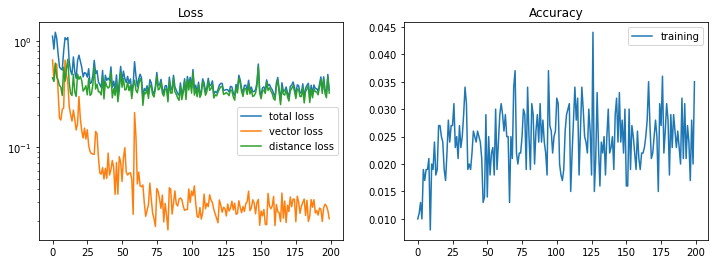

In [6]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='total loss')
plt.plot(tloss[:,0],tloss[:,2],label='vector loss')
plt.plot(tloss[:,0],tloss[:,3],label='distance loss')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,4],label='training')
plt.legend()
plt.title("Accuracy")

Light side is 0
True point ( 7.889962 , 2.4589316 )
Line drawn: m = -2, b = 15
True distance to the line: -1.4484602581811739
Predicted distance to the line: -1.094200469265378
TEST LOSS
-- Test vector loss: tensor(0.0013)
-- Test distance loss: tensor(0.3348, dtype=torch.float64)
COMPARE LOSS
-- Compare vector loss: 0.0012880129708842288
-- Compare distance loss: 0.33480718860193504


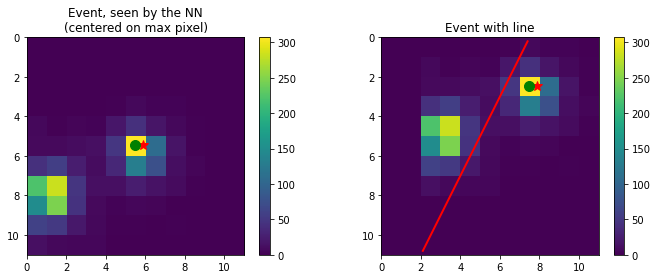

In [17]:
# Look at individual events
evt_plt = 14273
evt_item = dataset_val[evt_plt]
evt_frame_cmax = np.array(evt_item[0])
evt_frame      = np.array(evt_item[1])
evt_argmax     = np.array(evt_item[2])
evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE
evt_lside      = np.array(evt_item[4])
print("Light side is",evt_lside)

# Compute the true row and col.
row_true = evt_err[1] + evt_argmax[0] + 0.5
col_true = evt_err[0] + evt_argmax[1] + 0.5
print("True point (",col_true,",",row_true,")")

# Information for drawing the line.
nrows = evt_frame.shape[0]
ncols = evt_frame.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
print("Line drawn: m = {}, b = {}".format(line_m,line_b))

# Compute the distance from the true point to the line.
dist_true = (line_m*col_true - row_true + line_b) / (line_m**2 + 1)**0.5
print("True distance to the line:",dist_true)

# Run the model and compute the reconstructed point.
data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(data)
pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
row_pred = pred_err[1] + evt_argmax[0] + 0.5
col_pred = pred_err[0] + evt_argmax[1] + 0.5

# Compute the distance from the reconstructed point to the line.
dist_pred = (line_m*col_pred - row_pred + line_b) / (line_m**2 + 1)**0.5
print("Predicted distance to the line:",dist_pred)

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_frame_cmax,extent=[0,11,11,0])
ax1.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax1.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event, seen by the NN\n(centered on max pixel)")

ax1 = fig.add_subplot(132)
plt.imshow(evt_frame,extent=[0,11,11,0])
ax1.plot([col_true],[row_true],color='red',marker='*',markersize=10)
ax1.plot([col_pred],[row_pred],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event with line")
xfit = np.arange(0,ncols-1,0.1)
yfit = line_m*xfit + line_b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)],linewidth=2,color='red')

# Compute a test loss
print("TEST LOSS")
#loss_vec, loss_dist = tr.loss_reg_edge(torch.tensor([[evt_err[0],evt_err[1]]]), np.array([evt_argmax]), line_m, line_b, evt_lside)
loss_vec, loss_dist = tr.loss_reg_edge(torch.tensor([[pred_err[0],pred_err[1]]]), np.array([evt_argmax]), line_m, line_b, evt_lside)
print("-- Test vector loss:",loss_vec)
print("-- Test distance loss:",loss_dist)

print("COMPARE LOSS")
if(evt_lside == 0):
    dist_true *= -1
    dist_pred *= -1
sigma_dist = 1
loss_vec = (pred_err[0]**2 + pred_err[1]**2)
loss_dist = np.exp(-dist_pred/sigma_dist)
print("-- Compare vector loss:",loss_vec)
print("-- Compare distance loss:",loss_dist)
#print("True vector is ({},{})".format(evt_vec[0],evt_vec[1]))
#print("Predicted vector is ({},{})".format(pred_vec[0],pred_vec[1]))

In [9]:
# Evaluate several events
err_list = []
dist_list = []
maxval_list = []
err_x = []
err_y = []

for evt in range(0,20000):

    evt_item = dataset_val[evt]
    evt_frame_cmax = np.array(evt_item[0])
    evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE

    # Record the maximum event value.
    maxval_list.append(np.max(evt_frame_cmax))
    
    # Send through the model.
    data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
    
    # Compute the error.
    err = ((evt_err[0] - pred_err[0])**2 + (evt_err[1] - pred_err[1])**2)**0.5*emnet.PIXEL_SIZE
    dist = (evt_err[0]**2 + evt_err[1]**2)**0.5*emnet.PIXEL_SIZE
    ex = (evt_err[1] - pred_err[1])*emnet.PIXEL_SIZE
    ey = (evt_err[0] - pred_err[0])*emnet.PIXEL_SIZE
    
    err_list.append(err)
    err_x.append(ex)
    err_y.append(ey)
    dist_list.append(dist)
    
    if(evt % 100 == 0):
        print("Event",evt)
        
err_list = np.array(err_list)
err_x = np.array(err_x)
err_y = np.array(err_y)
dist_list = np.array(dist_list)

Event 0
Event 100
Event 200
Event 300
Event 400
Event 500
Event 600
Event 700
Event 800
Event 900
Event 1000
Event 1100
Event 1200
Event 1300
Event 1400
Event 1500
Event 1600
Event 1700
Event 1800
Event 1900
Event 2000
Event 2100
Event 2200
Event 2300
Event 2400
Event 2500
Event 2600
Event 2700
Event 2800
Event 2900
Event 3000
Event 3100
Event 3200
Event 3300
Event 3400
Event 3500
Event 3600
Event 3700
Event 3800
Event 3900
Event 4000
Event 4100
Event 4200
Event 4300
Event 4400
Event 4500
Event 4600
Event 4700
Event 4800
Event 4900
Event 5000
Event 5100
Event 5200
Event 5300
Event 5400
Event 5500
Event 5600
Event 5700
Event 5800
Event 5900
Event 6000
Event 6100
Event 6200
Event 6300
Event 6400
Event 6500
Event 6600
Event 6700
Event 6800
Event 6900
Event 7000
Event 7100
Event 7200
Event 7300
Event 7400
Event 7500
Event 7600
Event 7700
Event 7800
Event 7900
Event 8000
Event 8100
Event 8200
Event 8300
Event 8400
Event 8500
Event 8600
Event 8700
Event 8800
Event 8900
Event 9000
Event 9100


Text(0, 0.5, 'Counts/bin')

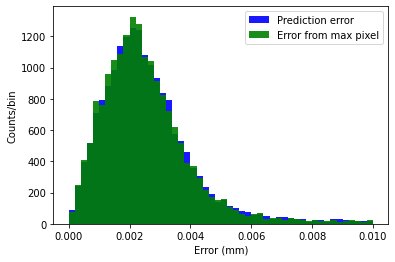

In [12]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

rng_max = 0.01
plt.hist(err_list,bins=50,color='blue',alpha=0.9,label="Prediction error",range=[0,rng_max])
plt.hist(dist_list,bins=50,color='green',alpha=0.9,label="Error from max pixel",range=[0,rng_max])
plt.legend()
plt.xlabel("Error (mm)")
plt.ylabel("Counts/bin")

Text(0, 0.5, 'Counts/bin')

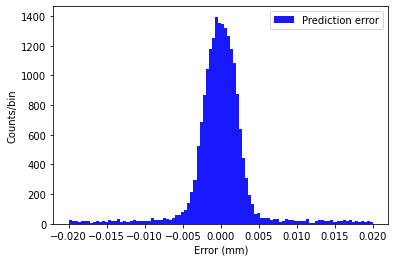

In [15]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

rng = 0.02
plt.hist(err_x*0.005,bins=100,color='blue',alpha=0.9,label="Prediction error",range=[-rng,rng])
plt.legend()
plt.xlabel("Error (mm)")
plt.ylabel("Counts/bin")

# Train the network (regression)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-5   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/regression/model_basicCNN_regression_vector_11x11.pt".format(modeldir)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset_train = tr.EMDataset("../dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=-1,nstart=20000)
dset_val = tr.EMDataset("../dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=-1,nstart=0,nend=20000)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset_train,frame_size=11,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=1)
dataset_val = tr.EMFrameDataset(dset_val,frame_size=11,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=1)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = emnet.basicCNN_reg()
#model = emnet.FCNet()
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_regression(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

## Plot a test event

In [ ]:
sigmoid = nn.Sigmoid()
model.eval()

In [ ]:
evt_plt = 14273
evt_item = dataset_val[evt_plt]
evt_arr = np.array(evt_item[0])
evt_vec = np.array(evt_item[1])

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
pred_vec = np.array(output_score.cpu().detach().numpy()).squeeze()

# Scale the errors.
# err_max = int(evt_arr.shape[0]-1)/2*emnet.PIXEL_SIZE
# err_rng = 2*err_max
# print("Max err is",err_max)
# evt_vec = (evt_vec*err_rng - err_max)/emnet.PIXEL_SIZE
# pred_vec = (pred_vec*err_rng - err_max)/emnet.PIXEL_SIZE

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
#ax1.plot([evt_vec[0]],[evt_vec[1]],color='red',marker='o',markersize=10)
plt.colorbar()
plt.plot([5+evt_vec[1]],[5+evt_vec[0]],color='red',marker='o',markersize=10)
plt.plot([5+pred_vec[1]],[5+pred_vec[0]],color='green',marker='o',markersize=10)
plt.title("Event")
print("True vector is ({},{})".format(evt_vec[0],evt_vec[1]))
print("Predicted vector is ({},{})".format(pred_vec[0],pred_vec[1]))

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

### Evaluate several events

In [ ]:
err_list = []
dist_list = []
maxval_list = []
err_x = []
err_y = []

for evt in range(0,20000):

    evt_item = dataset_val[evt]
    evt_arr = np.array(evt_item[0])
    evt_vec = np.array(evt_item[1])

    # Record the maximum event value.
    maxval_list.append(np.max(evt_arr))
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)

    # Compute the predicted pixel and (x,y) values.
    pred_vec = np.array(output_score.cpu().detach().numpy()).squeeze()
    
    # Scale the errors.
#     err_max = int(evt_arr.shape[0]-1)/2*emnet.PIXEL_SIZE
#     err_rng = 2*err_max
#     #print("Max err is",err_max)
#     evt_vec = (evt_vec*err_rng - err_max)/emnet.PIXEL_SIZE
#     pred_vec = (pred_vec*err_rng - err_max)/emnet.PIXEL_SIZE
    
    # Compute the error.
    err = ((evt_vec[0] - pred_vec[0])**2 + (evt_vec[1] - pred_vec[1])**2)**0.5
    dist = (evt_vec[0]**2 + evt_vec[1]**2)**0.5
    ex = evt_vec[1] - pred_vec[1]
    ey = evt_vec[0] - pred_vec[0]
    
    err_list.append(err)
    err_x.append(ex)
    err_y.append(ey)
    dist_list.append(dist)
    
    if(evt % 100 == 0):
        print("Event",evt)
        
err_list = np.array(err_list)
err_x = np.array(err_x)
err_y = np.array(err_y)
dist_list = np.array(dist_list)

In [ ]:
print(max(maxval_list))

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

plt.hist(err_list*0.005,bins=50,color='blue',alpha=0.9,label="Prediction error",range=[0,0.005])
plt.hist(dist_list*0.005,bins=50,color='green',alpha=0.9,label="Error from max pixel",range=[0,0.005])
plt.legend()
plt.xlabel("Error (mm)")
plt.ylabel("Counts/bin")
#plt.yscale("log")

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

rng = 0.05
plt.hist(err_x*0.005,bins=100,color='blue',alpha=0.9,label="Prediction error",range=[-rng,rng])
plt.legend()
plt.xlabel("Error (mm)")
plt.ylabel("Counts/bin")

In [ ]:
np.where(dist_list > 10)

# Generate random multi-electron events

In [ ]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

In [ ]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0, res_factor=3)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [ ]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 80):
    
    A = fit_img/np.mean(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2.0*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Force m and b.
    m = -2.0
    b = 90.0
    print("NOTE: hard-coding m and b")
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (5./3.)*(m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

In [ ]:
# Create some number of events and count them.
th_unet = 0.2
th_classical = 825/4.
evts = np.arange(0,100000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    gnd_truth = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    
    # Max argument classical truth.
    #ct_classical = np.zeros(frame.shape)
    #ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    # Threshold truth.
    ct_classical = label[1]
    
    l_frames.append(frame)
    l_labels.append(gnd_truth)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

In [ ]:
raw_th = 0.99
ct_th = 0.1
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

In [ ]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    #plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame (log counts)\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    #plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
#plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.title("Truth\nm = {:.2f}, b = {:.2f}".format(m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
#plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.title("UNet counts\nm = {:.2f}, b = {:.2f}".format(m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
#plt.title("Classical counts + line info (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.title("Classical counts + line info\nm = {:.2f}, b = {:.2f}".format(m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(hdist_frame))

ax1 = fig.add_subplot(121)
plt.plot(bcenters_frame,frame_mult*(hdist_frame-min(hdist_frame)),'.-',color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical+line')
plt.xlim([-10,10])
plt.ylim([0.0,3.2])
plt.xlabel("Distance from line (micrometers)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
# Save s-curve information.
np.savez("scurve_edge_th08_epoch10.npz", bcenters_frame=bcenters_frame, hdist_frame=hdist_frame, bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

In [ ]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_frame_edge = scurve_edge['bcenters_frame']
h_frame_edge = scurve_edge['hdist_frame']
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(h_frame_edge))

ax1 = fig.add_subplot(111)
plt.plot(bc_frame_edge,frame_mult*(h_frame_edge-min(h_frame_edge)),'.-',color='black',label='raw frame, scaled')
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='cyan',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([-5,5])
plt.ylim([0.0,1.0])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/model_init_199.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=3)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_noedge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [ ]:
sigmoid = nn.Sigmoid()
#dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

In [ ]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600/4,7000/4,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

In [ ]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.02])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [ ]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

In [ ]:
evt_plt = 10008
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
#modeldir = '/home/jrenner/local/jerenner/emsim/models'\
modeldir = '/home/jrenner/temp/nersc'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/run_11x11_chi32_60/model_init_599.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_short_training_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/val.txt")
#vloss = np.loadtxt("/home/jrenner/local/jerenner/emsim/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(100000,110000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
xvals = df['xc_3x3'].values
yvals = df['yc_3x3'].values
rngval = 0.002
plt.hist2d(xvals,yvals,bins=10,range=[[-rngval,rngval],[-rngval,rngval]])
plt.colorbar()

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.1
rng_cut = 0.005
sigma_cut = 1e9
nbins = 50

df_plt_NN  = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]
df_plt_3x3 = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]

plt.hist(df_plt_NN.error_r_NN,range=(0,rng_cut),alpha=0.8,bins=nbins,color='blue',label='NN error')
plt.hist(df_plt_3x3.error_r_3x3,range=(0,rng_cut),alpha=0.8,bins=nbins,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
#plt.yscale('log')
plt.legend()

print("NN events:",len(df_plt_NN[df_plt_NN.error_r_NN < rng_cut]))
print("3x3 events:",len(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut]))
print("Mean NN error:",np.mean(df_plt_NN[df_plt_NN.error_r_NN < rng_cut].error_r_NN))
print("Mean 3x3 error:",np.mean(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut].error_r_3x3))

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
df[df.x_true > 0.02][['event','x_true']]

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 80388
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN # - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX # + dset.add_shift*emnet.PIXEL_SIZE
#ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE
ERR_PIXEL_SIZE = (emnet.PIXEL_ERR_RANGE_MAX - emnet.PIXEL_ERR_RANGE_MIN)/emnet.ERR_SIZE
print("Error grid pixel size is {}".format(ERR_PIXEL_SIZE))

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
print(x_errgrid)

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))